In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import igraph as ig

# Load the graph

In [3]:
G = ig.read("data/bitcoin/bitcoinotc.graphml")

In [4]:
G.to_undirected(combine_edges="first")

In [21]:
G.summary()

'IGRAPH U-W- 5881 21492 -- \n+ attr: b (v), g (v), id (v), label (v), r (v), size (v), x (v), y (v), Edge Label (e), id (e), rating (e), time (e), weight (e)'

# Clique distribution

In [5]:
G.clique_number()

11

In [6]:
cl = G.cliques()

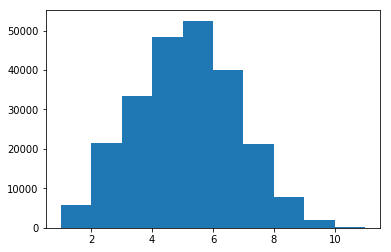

In [7]:
plt.hist(list(map(len,cl)), bins=10);

# Rescale the timestamps

In [8]:
edges = pd.DataFrame([e.attributes().values() for e in G.es])
edges.columns = G.es.attribute_names()
edges.drop(["Edge Label", "id"], axis=1, inplace=True)
edges.describe()

,weight,rating,time
count,21492.0,21492.000000,2.149200e+04
mean,1.0,0.641495,1.356940e+09
std,0.0,3.935859,3.309691e+07
min,1.0,-10.000000,1.289242e+09
25%,1.0,1.000000,1.334097e+09
50%,1.0,1.000000,1.360080e+09
75%,1.0,2.000000,1.377251e+09
max,1.0,10.000000,1.453680e+09


In [9]:
timerange = edges.time.max() - edges.time.min()
timemin = edges.time.min()
G.es["time"] = (G.es["time"] - timemin) / timerange

# Temporal subgraphs

In [10]:
G.subgraph_edges(G.es(lambda e: e["time"] < 0.1)).summary()

'IGRAPH U-W- 570 1378 -- \n+ attr: b (v), g (v), id (v), label (v), r (v), size (v), x (v), y (v), Edge Label (e), id (e), rating (e), time (e), weight (e)'

In [11]:
def temporal_subgraph(graph, tmin=None, tmax=None, delete_vertices=True):
    if tmin==None:
        tmin = min(graph.es["time"])
    if tmax==None:
        tmax = max(graph.es["time"])
    return G.subgraph_edges(G.es(lambda e: (e["time"] > tmin) & (e["time"] < tmax)), delete_vertices=delete_vertices)

In [12]:
temporal_subgraph(G, tmin=0.1, tmax=0.3).summary()

'IGRAPH U-W- 1788 4605 -- \n+ attr: b (v), g (v), id (v), label (v), r (v), size (v), x (v), y (v), Edge Label (e), id (e), rating (e), time (e), weight (e)'

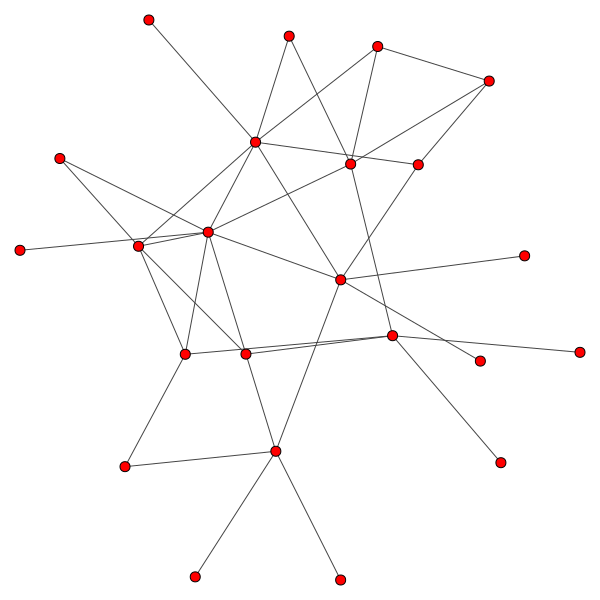

In [13]:
ti = 0
dt = 0.01
subg = temporal_subgraph(G, tmin=ti, tmax=ti+dt)
layout = subg.layout("kk")
ig.plot(subg, layout=layout)

# Export multilayer graph

In [14]:
dt = 0.05
layout = []
subg = []
for i in range(2):
    subg.append(temporal_subgraph(G, tmin=i*dt, tmax=i*dt+dt))
    layout.append(subg[i].layout("kk").coords)

In [15]:
vs_df = pd.DataFrame()
es_df = pd.DataFrame()
for i in range(2):
    subg_vs = pd.DataFrame(layout[i])
    subg_vs.columns = ["x","y"]
    subg_vs["id"] = np.arange(len(layout[i]))
    subg_vs["layer"] = i+1
    # subg_vs.to_csv("vs1.csv", index=False)
    vs_df = pd.concat([vs_df,subg_vs])
    subg_es = pd.DataFrame([[e.source,e.target] for e in subg[i].es])
    subg_es.columns = ["u","v"]
    # subg_es.to_csv("es1.csv", index=False)
    es_df = pd.concat([es_df,subg_es])
    
vs_df.to_csv("vs.csv", index=False)
es_df.to_csv("es.csv", index=False)